# Tutorial III: Sequence-to-Sequence Regression
###Acknowledgment
1.   This tutorial was prepared by Najee Stubbs at the University of Arkansas (nistubbs@uark.edu).
2.   The development of this tutorial was supported by a gift from MathWorks through the MathWorks Curriculum Development Support program.
3.   The dataset and algorithms used in this tutorial are from C. Dunlap, H. Pandey, E. Weems, and H. Hu, “Nonintrusive Heat Flux Quantification Using Acoustic Emissions During Pool Boiling,” Appl. Therm. Eng., 228, (2023) 120558.[[link](https://www.sciencedirect.com/science/article/pii/S1359431123005872?casa_token=iu_sglcp8_YAAAAA:l0EY8ULX9K1S3vgL3zfuYzaGVOyGXM1855zB4lPylGaTw5oBKeaDAJjwz0xtoIiaZBaCVQyky4w)] and H. Hu and C. Heo, “Integration of Data Science into Thermal-Fluids Engineering Education”, in Proceedings of the ASME 2022 International Mechanical Engineering Congress and Exposition, Oct – Nov 2022, Columbus, OH, IMECE2022-88193. [[link](https://asmedigitalcollection.asme.org/IMECE/proceedings/IMECE2022/86694/V007T09A023/1157305?casa_token=WkPBi8YP3mAAAAAA:J3cvx7ws3o9zaKg30YIbuP3w2VqRHjM070xr5g982v0SLKQCuVN_kpSWxUjVJHyo6FP3BEaD)]
4.   This tutorial was implemented in MEEG tech elective "Machine Learning for Mechanical Engineers." [[link](https://ned3.uark.edu/teaching/)]

# **1. Import Libraries**

In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score, explained_variance_score

from tqdm.notebook import tqdm # for progress bar in parametric studies

# If using Google Colab, import necessary library for file uploads
from google.colab import files

# **2. Load Data**

##### 2.1 Define function to load and visualize raw data

In [ ]:
def load_rawData():
  """
  Load and preview a raw dataset file that has one feature.
  The first column is assumed to be the time column.

  Returns:
  - rawData: DataFrame containing the uploaded data.
  """

  # Upload the raw data file
  uploaded = files.upload()
  filename = list(uploaded.keys())[0]
  rawData = pd.read_csv(filename, delimiter='\t')

  # Preview the first few rows of the raw data
  display(rawData.head())

  # Inspect the statistics of the raw data
  display(rawData.describe().transpose())

  # Assuming the first column represents time and, the second a feature
  time_col = rawData.columns[0]
  feature_col = rawData.columns[1]

  # Visualize the raw data
  plt.figure(figsize=(14, 6))
  plt.plot(rawData[time_col], rawData[feature_col])
  plt.xlabel(time_col)
  plt.ylabel(feature_col)
  plt.title(f'Visualization of {feature_col} over {time_col}')
  plt.show()

  # Return the loaded raw data as a DataFrame
  return rawData

##### 2.2 Load and visualize raw data

Saving DS-1_36W_vapor_fraction.txt to DS-1_36W_vapor_fraction (1).txt


,Time (ms),Vapor Fraction
0,0.333333,0.566644
1,0.666667,0.564461
2,1.000000,0.562855
3,1.333333,0.565662
4,1.666667,0.563902


,count,mean,std,min,25%,50%,75%,max
Time (ms),4999.0,833.333333,481.077109,0.333333,416.833333,833.333333,1249.833333,1666.333333
Vapor Fraction,4999.0,0.531847,0.052238,0.365338,0.502484,0.532094,0.561969,0.695138


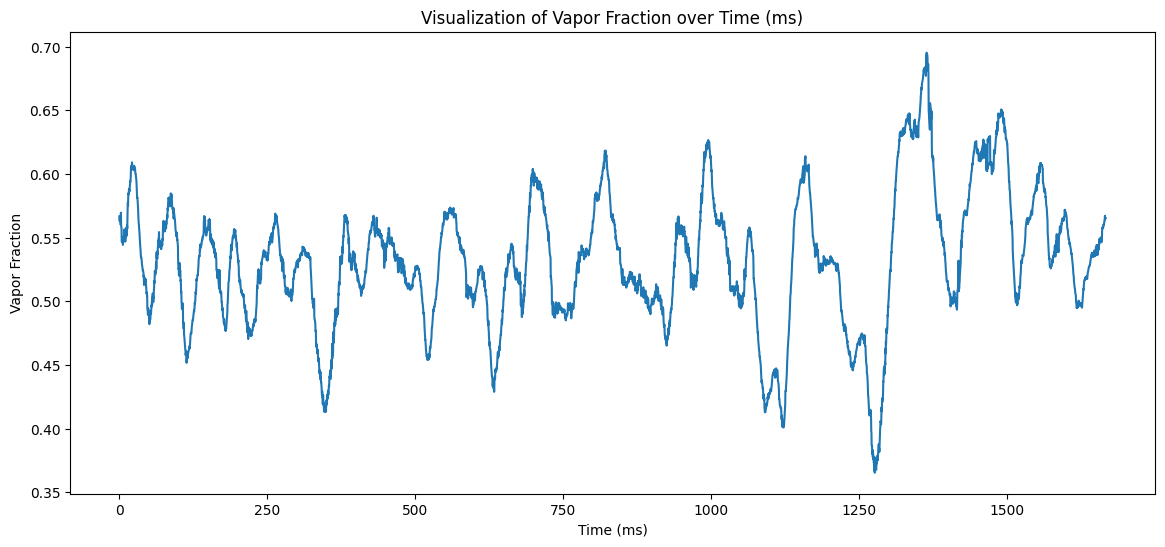

In [ ]:
rawData = load_rawData()

# **3. Preprocess Data**

##### 3.1 Define function to generate dataset for preprocessing

In [ ]:
def generate_dataset(rawData, input_window_size, output_window_size, stride):
  """
  Generate input and output sequences for time series regression, only considering the feature values.

  Parameters:
  - rawData: The raw time series data.
  - input_window_size: Number of past observations used as input.
  - output_window_size: Number of future observations to be predicted.
  - stride: Step size to move over the rawData for sampling subsequences.

  Returns:
  - X: Input sequences for the model.
  - y: Corresponding output sequences for the model.
  """

  # Initialize empty lists to hold input and output sequences
  X, y = [], []

  # Extract only the feature values from the raw data (ignoring the time column)
  feature_values = rawData[rawData.columns[1]].values

  # Calculate the total window size (input + output)
  total_window_size = input_window_size + output_window_size

  # Iterate over the feature values to generate sequences
  for i in range(0, len(feature_values) - total_window_size + 1, stride):
    # Extract the input sequence based on the current position and input window size
    seq_x = feature_values[i:i+input_window_size]

    # Extract the output sequence based on the current position, input window size, and output window size
    seq_y = feature_values[i+input_window_size:i+total_window_size]

    # Append the extracted sequences to the respective lists
    X.append(seq_x)
    y.append(seq_y)

  # Convert the lists to numpy arrays for better compatibility with machine learning frameworks
  return np.array(X), np.array(y)

##### 3.2 Define function to Split Dataset and Reshape Input Sequence Data to be input into LSTM Model

In [ ]:
def split_and_reshape_dataset(X, y, input_window_size, output_window_size):
  """
  Split the dataset into training, validation, and test sets and reshape for LSTM input.

  Parameters:
  - X: Input sequences for the model.
  - y: Corresponding output sequences for the model.
  - input_window_size: Number of past observations in each input sequence.
  - output_window_size: Number of future observations in each output sequence.

  Returns:
  - X_train, X_val, X_test: Reshaped input sequences for training, validation, and testing.
  - y_train, y_val, y_test: Corresponding output sequences for training, validation, and testing.
  """
  # Predefined parameters for splitting the dataset
  test_size = 0.2     # Fraction of the dataset to be used as the test set.
  val_ratio = 0.1     # Fraction of the (non-test) dataset to be used as the validation set.
  random_state = 42   # Seed for reproducible train-test splits.

  # Split the dataset into a temporary set and a test set
  X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

  # Split the temporary set further into training and validation sets
  X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_ratio, random_state=random_state)

  # Helper function to reshape data
  def reshape_data(data, window_size):
    return data.reshape(-1, window_size, 1)

  # Reshape the datasets to fit the LSTM input shape requirements
  X_train, X_val, X_test = [reshape_data(data, input_window_size) for data in [X_train, X_val, X_test]]
  y_train, y_val, y_test = [reshape_data(data, output_window_size) for data in [y_train, y_val, y_test]]

  return X_train, X_val, X_test, y_train, y_val, y_test

##### 3.3 Generate and preprocess dataset from raw data

In [ ]:
# Define Parameters
# the parameter 'rawData' was already define in previous steps.
input_window_size = 25
output_window_size = 25
stride = 25

# Generate the dataset
X, y = generate_dataset(rawData, input_window_size, output_window_size, stride)

# Split and reshape the dataset
X_train, X_val, X_test, y_train, y_val, y_test = split_and_reshape_dataset(X, y, input_window_size, output_window_size)

# Print shapes of the variables
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X: (198, 25)
Shape of y: (198, 25)
Shape of X_train: (142, 25, 1)
Shape of X_val: (16, 25, 1)
Shape of X_test: (40, 25, 1)
Shape of y_train: (142, 25, 1)
Shape of y_val: (16, 25, 1)
Shape of y_test: (40, 25, 1)


# **4. Train Model**

##### 4.1 Define callback to track training time

In [ ]:
class trainingTime(tf.keras.callbacks.Callback):
  """
  Keras callback to track the training time for each epoch.

  Attributes:
  - times (list): List to store the training time for each epoch.
  """

  def on_train_begin(self, logs=None):
      self.times = []

  def on_epoch_begin(self, epoch, logs=None):
      self.epoch_time_start = time.time()

  def on_epoch_end(self, epoch, logs=None):
      training_time = time.time() - self.epoch_time_start
      self.times.append(training_time)
      logs['training_time'] = training_time

##### 4.2 Define callback to track training improvement

In [ ]:
earlyStopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-5,  # Adjusted based on the change in val_loss
    patience=30,
    verbose=0,
    mode='auto',
    restore_best_weights=True)

##### 4.3 Define function to plot training results

In [ ]:
def plot_training_results(history, metric_names, input_window_size, output_window_size, stride):
  """
  Plot training results from the training history.

  Parameters:
  - history: Training history object from model.fit.
  - metric_names (list of str): List of metric names to plot. Example: ['loss', 'mean_absolute_error']
  - input_window_size (int): Size of the input sequence.
  - output_window_size (int): Size of the output sequence.
  - stride (int): Stride value used for sampling the dataset.
  """
  # Extract training times from the history object
  training_times = history.history['training_time']

  num_metrics = len(metric_names)
  fig, axes = plt.subplots(nrows=1, ncols=num_metrics + 1, figsize=(6*(num_metrics + 1), 6))  # One plot for each metric and one for training time

  # Title for the plots
  plot_title = f"Metrics for Input Length: {input_window_size}, Output Length: {output_window_size}, Stride: {stride}"

  # Plotting the training times
  axes[0].plot(training_times, label='Training Time', color='green')
  axes[0].legend()
  axes[0].set_title('Training Time vs Epochs')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Time (s)')
  axes[0].grid(True)

  # Plotting the metrics
  for idx, metric_name in enumerate(metric_names, start=1):
    axes[idx].plot(history.history[metric_name], label=f'Training {metric_name}', color='blue')
    axes[idx].plot(history.history[f'val_{metric_name}'], label=f'Validation {metric_name}', color='red')
    axes[idx].legend()
    axes[idx].set_title(metric_name.capitalize())
    axes[idx].set_xlabel('Epochs')
    axes[idx].set_ylabel(metric_name)
    axes[idx].grid(True)

  fig.suptitle(plot_title, y=1.05)
  plt.tight_layout()
  plt.show()

##### 4.4 Define function to build and compile model

In [ ]:
def build_and_compile_model(input_window_size, output_window_size):
  """
  Builds and compiles a LSTM-based regression model for time series data.

  Parameters:
  - input_window_size (int): Size of the input sequence to the model.
  - output_window_size (int): Size of the output sequence from the model.

  Returns:
  - model (tf.keras.Model): Compiled LSTM model.
  """

  # Define the model architecture
  model = tf.keras.models.Sequential([
      # First LSTM layer with 50 units, returning sequences for the next LSTM layer
      tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(input_window_size, 1)),
      # Dropout layer for regularization
      tf.keras.layers.Dropout(0.2),
      # Second LSTM layer with 50 units
      tf.keras.layers.LSTM(50, return_sequences=False),
      # Another dropout layer for regularization
      tf.keras.layers.Dropout(0.2),
      # Dense output layer to produce the predicted sequence
      tf.keras.layers.Dense(output_window_size)
  ])

  # Compile the model with Mean Squared Error loss, Adam optimizer, and Mean Absolute Error as an additional metric
  model.compile(
      loss=tf.keras.losses.MeanSquaredError(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=[tf.keras.metrics.MeanAbsoluteError()]
  )

  return model

##### 4.5 Build, compile, and train the model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 25, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
Total params: 31875 (124.51 KB)
Trainable params: 31875 (124.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
5/5 [==

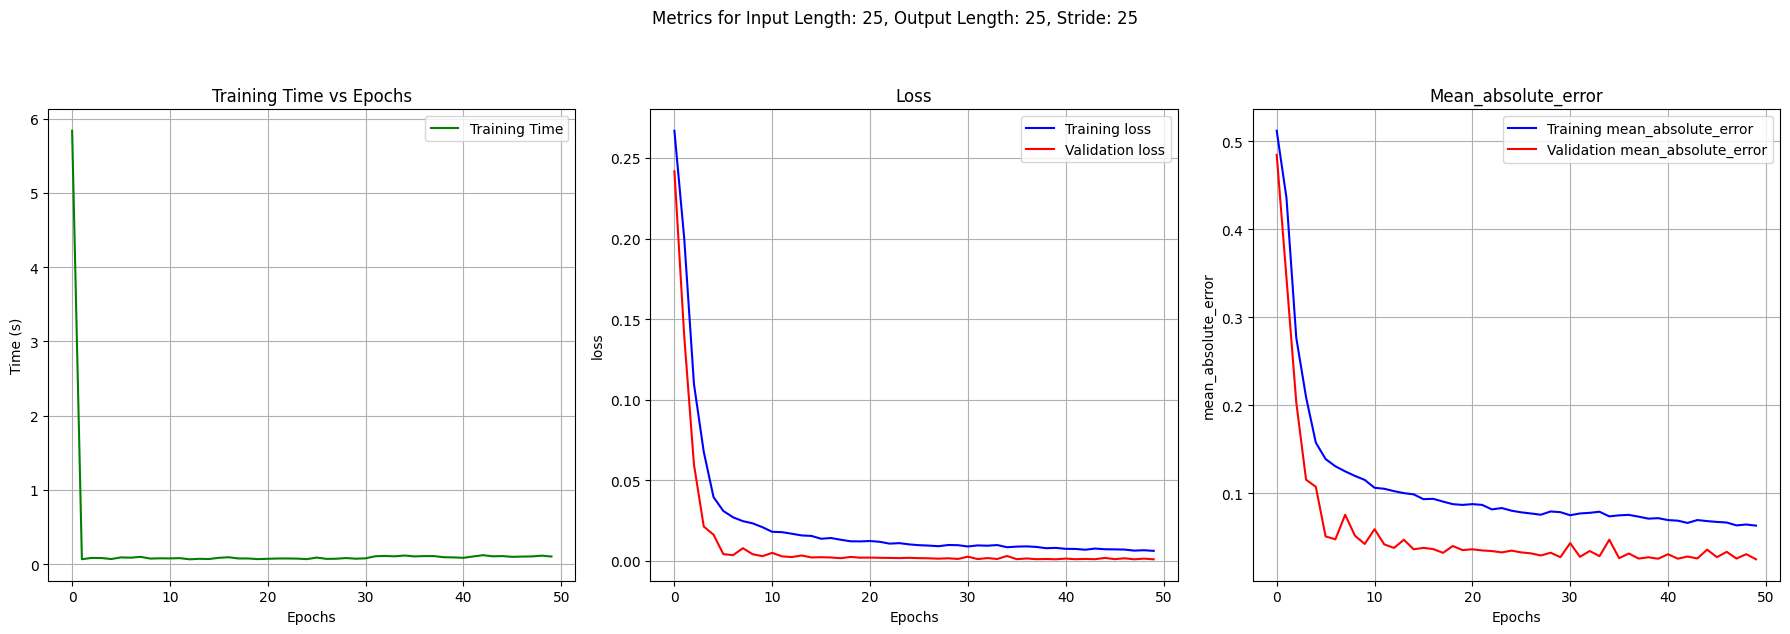

In [ ]:
# Define Parameters
# all parameters are already define in previous steps.

# Build and Compile LSTM Model
model = build_and_compile_model(input_window_size, output_window_size)

# Display Model Summary
model.summary()

# Train Model
history = model.fit(
    X_train, y_train,          # Training data
    epochs=50,                 # Number of epochs
    batch_size=32,             # Batch size
    validation_data=(X_val, y_val),  # Validation data
    shuffle=False,             # Don't shuffle time series data
    callbacks=[trainingTime(), earlyStopping])  # Apply training time tracking and early stopping callbacks

# Plot Training Results
# Example of how to use:
metrics_to_plot = ['loss', 'mean_absolute_error']
plot_training_results(history, metrics_to_plot, input_window_size, output_window_size, stride)

# **5. Evaluate and Test Model**

##### 5.1 Define Function to evaluate the trained model to assess its performance

In [ ]:
def evaluate_prediction_metrics(y_true, predictions):
  """
  Evaluate regression metrics based on true values and predictions.

  Parameters:
  - y_true: True output values.
  - predictions: Predicted values.

  Returns:
  - A DataFrame with computed metrics (MAE, RMSE, R-squared, and Explained Variance).
  """

  # Compute metrics
  mae = mean_absolute_error(y_true.flatten(), predictions.flatten())
  rmse = mean_squared_error(y_true.flatten(), predictions.flatten(), squared=False)
  r2_val = r2_score(y_true.flatten(), predictions.flatten())
  explained_var = explained_variance_score(y_true.flatten(), predictions.flatten())

  # Create a DataFrame for the metrics
  metrics_df = pd.DataFrame({
      "MAE": [mae],
      "RMSE": [rmse],
      "R-squared": [r2_val],
      "Explained Variance": [explained_var]})

  return metrics_df

##### 5.2 Define function to visualize local comparison between predicted and true sequences

In [ ]:
def plot_localComparison(X_test, y_test, predictions, input_window_size, output_window_size, stride):
  """
  Plot a local comparison of true future values against predicted future values for random samples,
  followed by a plot comparing the last values from each sequence of the entire test set.
  Additionally, highlights the samples shown in the local comparison on the plot of all test predictions.

  Parameters:
  - X_test: Input test data.
  - y_test: True output values for the test data.
  - predictions: Predicted values.
  - input_window_size: Number of steps in the input sequence.
  - output_window_size: Number of steps in the output sequence.
  - stride: The stride used for sliding window.
  """
  total_window_size = input_window_size + output_window_size

  fig, axes = plt.subplots(1, 2, figsize=(14,6))  # Create 2 subplots for local comparison
  num_samples = X_test.shape[0]  # Total number of samples in X_test

  highlighted_indices = []  # List to store the random indices for highlighting later

  for ax in axes:
    # Randomly pick an index
    rand_idx = np.random.choice(num_samples)
    highlighted_indices.append(rand_idx)

    ax.plot(np.arange(0, input_window_size), X_test[rand_idx, :, 0], 'b-', label='Input Sequence')
    ax.plot(np.arange(input_window_size, total_window_size), y_test[rand_idx], 'ro', label='True Future')
    ax.plot(np.arange(input_window_size, total_window_size), predictions[rand_idx], 'gx', label='Predicted Future')

    ax.legend(loc='best')
    ax.set_title(f'Predictions vs Actual (Sample Index: {rand_idx})\nInput Window: {input_window_size}, Output Window: {output_window_size}, Stride: {stride}')
    ax.set_xlabel('Time Step (0.33ms each)')
    ax.set_ylabel('Vapor Fraction')
    ax.set_xlim(left=0)  # Ensure x-axis starts from 0
    ax.grid(True)

  plt.tight_layout()
  plt.show()

  # Plot comparing the last values from each sequence of the entire test set
  y_test_last_values = y_test[:, -1]
  y_pred_last_values = predictions[:, -1]

  plt.figure(figsize=(15, 6))
  plt.plot(y_test_last_values, label='True Test Values', color='green')
  plt.plot(y_pred_last_values, label='Predicted Test Values', color='red', alpha=0.7)

  # Highlight the samples shown in the local comparison
  for idx in highlighted_indices:
    plt.axvspan(idx-0.5, idx+0.5, color='yellow', alpha=0.5, label='Highlighted Samples' if 'Highlighted Samples' not in plt.gca().get_legend_handles_labels()[1] else "")

  plt.xlim(left=0)  # Ensure x-axis starts from 0
  plt.legend()
  plt.title(f'Model Predictions vs. True Test Values\nInput Window: {input_window_size}, Output Window: {output_window_size}, Stride: {stride}')
  plt.xlabel('Time Steps (0.33ms each)')
  plt.ylabel('Vapor Fraction')
  plt.grid(True)
  plt.show()

##### 5.3 Make predictions and evaluate the trained model

,MAE,RMSE,R-squared,Explained Variance
0,0.023191,0.030241,0.614861,0.643759


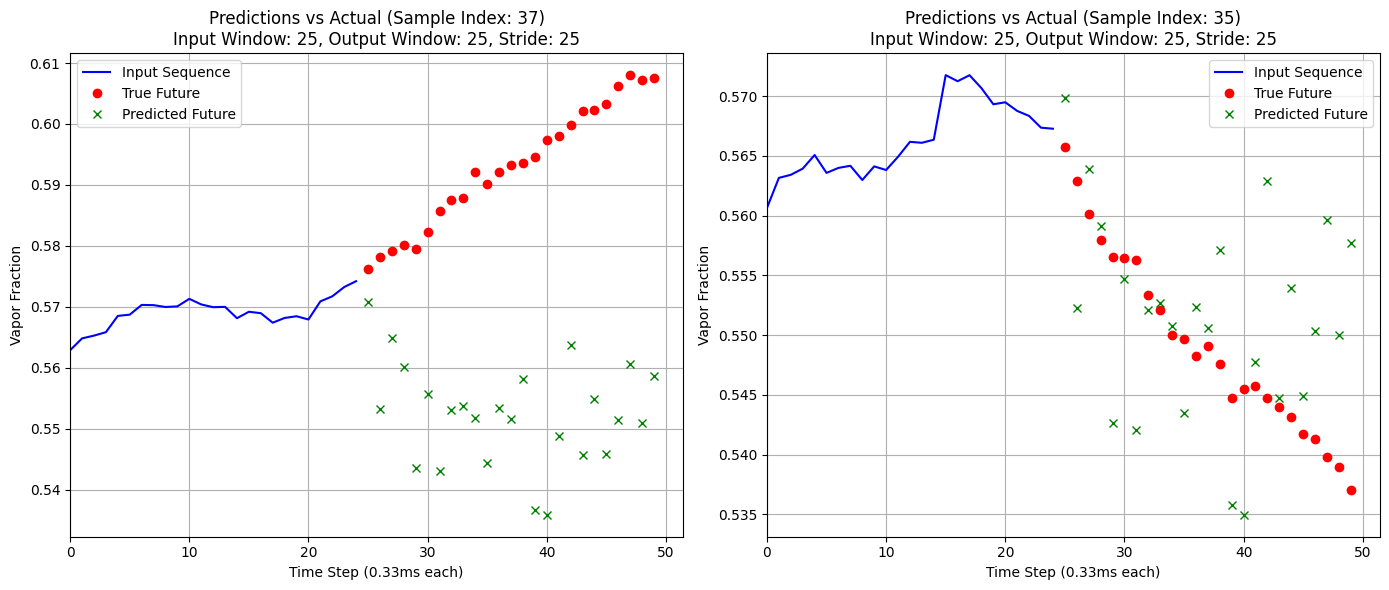

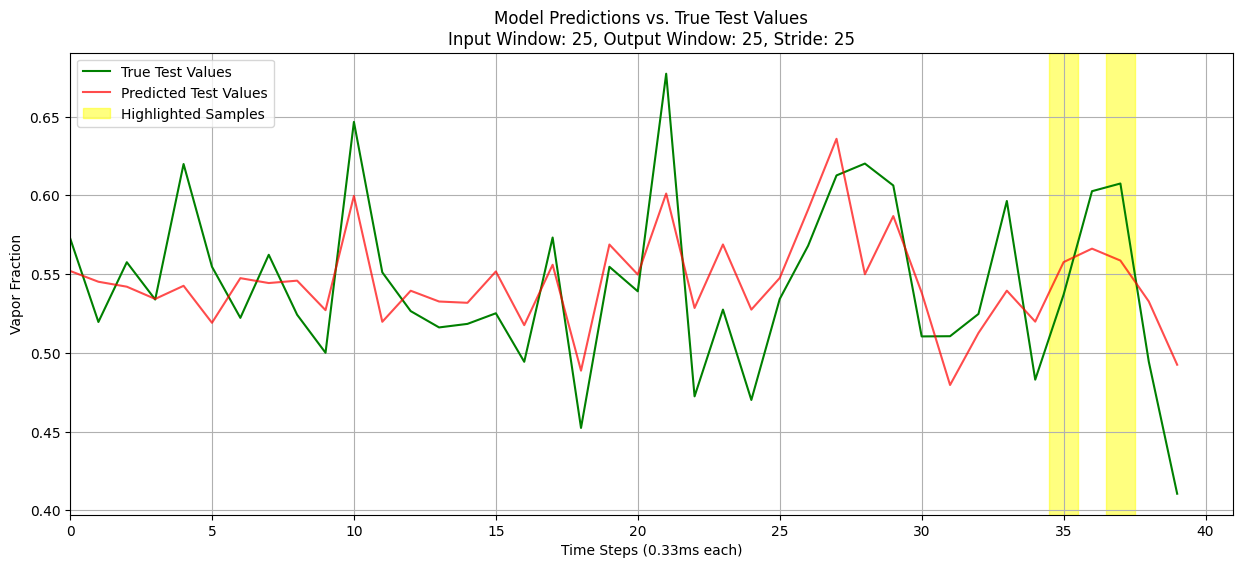

In [ ]:
# Make predictions
predictions = model.predict(X_test, verbose=0)

# Evaluate trained model's performance
metrics_df =  evaluate_prediction_metrics(y_test, predictions)
display(metrics_df)

# Visualize Prediction Results
plot_localComparison(X_test, y_test, predictions, input_window_size, output_window_size, stride)

# **6. Parametric Study**

##### 6.1 Define function containing parametric study, procedure

In [ ]:
def parametric_study_with_metrics(rawData, input_window_sizes, output_window_sizes, strides):
    """
    Conduct a parametric study on provided raw data using various input and output window sizes and strides.
    Trains a model on generated datasets and evaluates its performance using MAE.
    Plots the MAE values in a heatmap format for visualization.
    Progress bars are displayed for strides, input window sizes, and output window sizes
    to provide a visual indication of the study's progress.

    Parameters:
    - rawData: The raw data to generate datasets from.
    - input_window_sizes: List of sizes for input window.
    - output_window_sizes: List of sizes for output window.
    - strides: List of stride values to use.

    Returns:
    - results_dict: Dictionary containing MAE values for each combination of parameters.
    - metrics_dict: Dictionary containing detailed metrics for each combination of parameters.
    """

    results_dict = {}  # To store the results
    metrics_dict = {}  # To store the overall metrics for each combination

    # Iterate over each stride value
    for stride in tqdm(strides, desc="Strides Progress"):
        results_matrix = []  # To store results for each stride
        metrics_matrix = []  # To store metrics for each stride

        # Iterate over each input window size
        for input_window_size in tqdm(input_window_sizes, desc="Input Window Sizes Progress", leave=False):
            row_results = []  # To store results for each input window size
            row_metrics = []  # To store metrics for each input window size

            # Iterate over each output window size
            for output_window_size in tqdm(output_window_sizes, desc="Output Window Sizes Progress", leave=False):

                # Generate the dataset based on current loop parameters
                X, y = generate_dataset(rawData, input_window_size, output_window_size, stride)

                # Split and reshape the dataset based on current input_window_size
                X_train, X_val, X_test, y_train, y_val, y_test = split_and_reshape_dataset(X, y, input_window_size, output_window_size)

                # Build and compile the model
                model = build_and_compile_model(input_window_size, output_window_size)

                # Train the model
                model.fit(X_train, y_train,
                          epochs=50,
                          batch_size=32,
                          validation_data=(X_val, y_val),
                          shuffle=False,
                          callbacks=[earlyStopping],
                          verbose=0)

                # Predict on test data
                predictions = model.predict(X_test, verbose=0)

                # Evaluate prediction metrics
                metrics_df = evaluate_prediction_metrics(y_test, predictions)

                row_results.append(metrics_df["MAE"].values[0])
                row_metrics.append(metrics_df)

            results_matrix.append(row_results)
            metrics_matrix.append(row_metrics)

        results_dict[stride] = results_matrix
        metrics_dict[stride] = metrics_matrix

    # Plotting the results in a heatmap format
    for stride, data in results_dict.items():
        df = pd.DataFrame(data, index=input_window_sizes, columns=output_window_sizes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(df, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Mean Absolute Error'})
        plt.title(f'MAE for Stride {stride}')
        plt.xlabel('Output Sequence Length')
        plt.ylabel('Input Sequence Length')
        plt.show()

    return results_dict, metrics_dict

##### 6.2 Perform a parametric study on the model

Strides Progress:   0%|          | 0/2 [00:00<?, ?it/s]

Input Window Sizes Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Output Window Sizes Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Output Window Sizes Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Output Window Sizes Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Output Window Sizes Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Output Window Sizes Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Output Window Sizes Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Output Window Sizes Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Output Window Sizes Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Input Window Sizes Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Output Window Sizes Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Output Window Sizes Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Output Window Sizes Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Output Window Sizes Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Output Window Sizes Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Output Window Sizes Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Output Window Sizes Progress:   0%|          | 0/8 [00:00<?, ?it/s]

Output Window Sizes Progress:   0%|          | 0/8 [00:00<?, ?it/s]

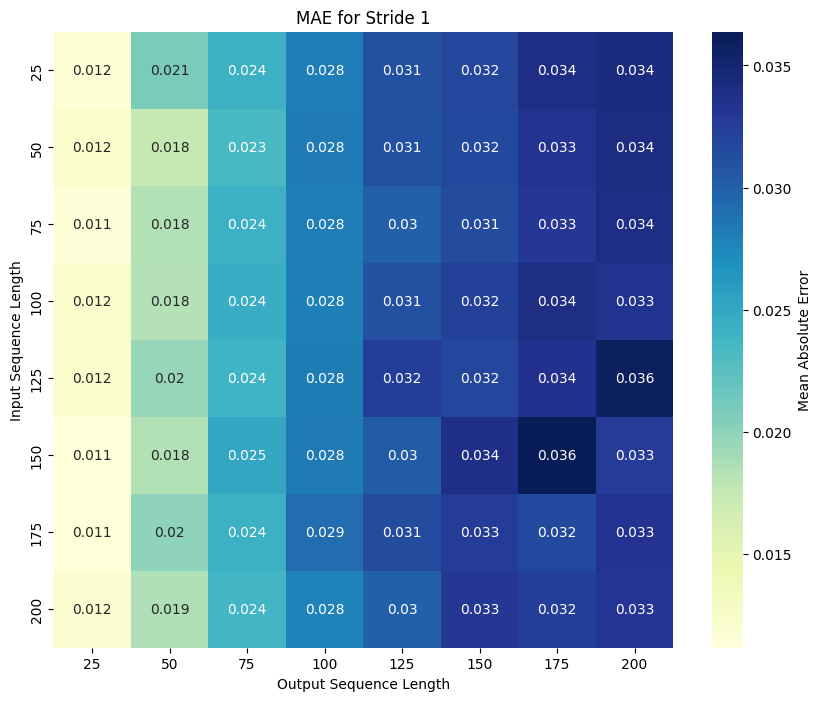

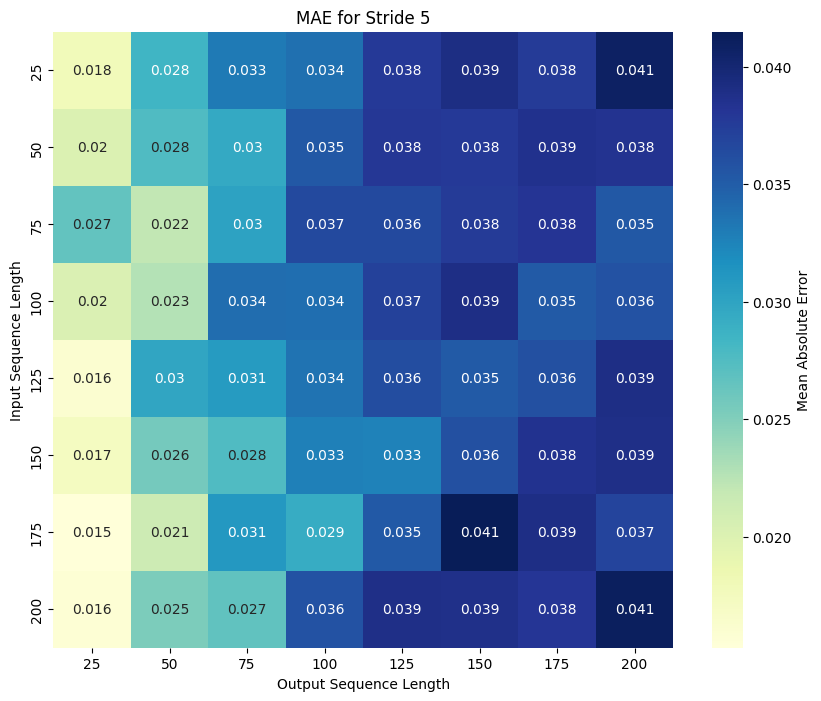

In [ ]:
# Define parametric study parameters
para_input_window_sizes = [25, 50, 75, 100, 125, 150, 175, 200]
para_output_window_sizes = [25, 50, 75, 100, 125, 150, 175, 200]
para_strides = [1, 5]

# Perform Parametric Study
results, metrics = parametric_study_with_metrics(rawData, para_input_window_sizes, para_output_window_sizes, para_strides)